In [1]:
### Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Load data
df_path_abun = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/pathways_out/path_abun_contrib.tsv', sep='\t', dtype=str, header=0, usecols=['sample', 'function', 'taxon', 'taxon_abun', 'taxon_function_abun'])
df_path_abun_unstrat = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_unstratified/picrust2_out_pipeline_lasse/pathways_out/path_abun_unstrat.tsv', sep='\t', dtype=str, header=0)
df_tax = pd.read_csv('~/Thesis/data/tax_complete_qiime.txt', sep='\t', dtype=str, header=None, names=['taxon', 'taxonomy'])
df_meta = pd.read_csv('~/Thesis/data/metadata.txt', sep='\t', dtype=str, header=0, usecols=['Barcode ', 'ReactorID', 'SampleDate'])
df_nsti = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/KO_metagenome_out/weighted_nsti.tsv', sep='\t', dtype=str, header=0)
df_asv_nsti = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/marker_predicted_and_nsti.tsv', sep='\t', dtype=str, header=0, usecols=['sequence', 'metadata_NSTI'])   

# Remove invisible spacings
df_path_abun['sample'] = df_path_abun['sample'].str.strip()

In [3]:
### Save files
df_path_abun.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_path_abun.tsv', sep='\t', index=False)
df_tax.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_tax.tsv', sep='\t', index=False)
df_meta.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_meta.tsv', sep='\t', index=False)
df_nsti.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_nsti.tsv', sep='\t', index=False)

In [4]:
# Filter for PR1 and PR4
barcodes = df_meta[df_meta['ReactorID'].isin(['PR1', 'PR4'])]['Barcode '].tolist()
df_path_abun = df_path_abun[df_path_abun['sample'].isin(barcodes)].copy()

PR1 = df_meta[df_meta['ReactorID'].isin(['PR1'])]['Barcode '].tolist()
PR4 = df_meta[df_meta['ReactorID'].isin(['PR4'])]['Barcode '].tolist()

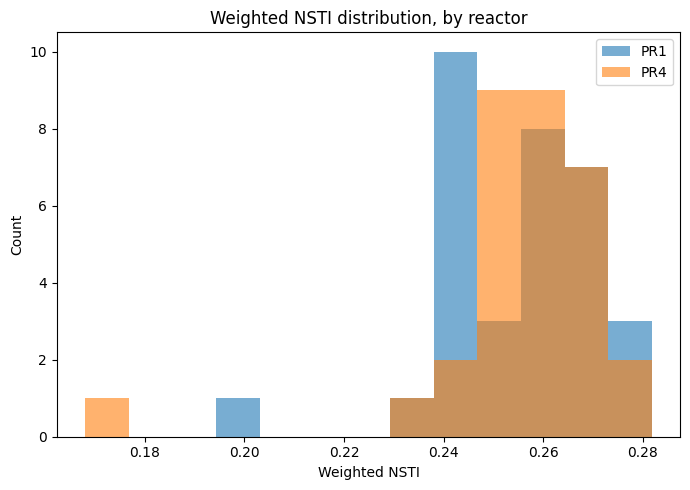

In [ ]:
### Weighted NSTI distribution

# Numeric values
df_nsti['weighted_NSTI'] = pd.to_numeric(df_nsti['weighted_NSTI'], errors='coerce').copy()


# Generate boolean masks for PR1 and PR4
mask_pr1 = df_nsti['sample'].isin(PR1)
mask_pr4 = df_nsti['sample'].isin(PR4)

# Bins
all_vals = df_nsti.loc[mask_pr1 | mask_pr4, 'weighted_NSTI'].dropna().values
bins = np.histogram_bin_edges(all_vals, bins='auto') if len(all_vals) else 20

# Histogram of weighted NSTI values
plt.figure(figsize=(7, 5))
plt.hist(df_nsti.loc[mask_pr1, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR1', density=False)
plt.hist(df_nsti.loc[mask_pr4, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR4', density=False)
plt.xlabel('Weighted NSTI')
plt.ylabel('Count')
plt.title('Weighted NSTI distribution, by reactor')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
### Compute genus-level pathway abundances

# Pathways of interest
pathways = ['METH-ACETATE-PWY', # Acetoclastic methanogenesis
            'METHANOGENESIS-PWY'] # Hydrogenotrophic methanogenesis


# Keep what's needed
df = df_path_abun[['sample', 'function', 'taxon', 'taxon_function_abun']].copy()


# Ensure numeric abundance
df['taxon_function_abun'] = pd.to_numeric(df['taxon_function_abun'], errors='coerce').fillna(0.0)


# Fix whitespacing
df_tax["taxon"] = df_tax["taxon"].str.strip()
df_tax["taxonomy"] = df_tax["taxonomy"].str.strip()


# Merge taxonomy onto pathway abundance data
df = df.merge(df_tax, on='taxon', how='left').copy()


# Split taxonomies up into seperate columns
ranks = {
    "kingdom": "k__", "phylum": "p__", "class": "c__", "order": "o__",
    "family": "f__", "genus": "g__", "species": "s__"
}


# Extract each rank from the semicolon-delimited string
for col, prefix in ranks.items():
    df[col] = df["taxonomy"].str.extract(fr"{prefix}\s*([^;]+)", expand=False).str.strip()


# Collapse ASV level pathway abundance to genus-level pathway abundance
PR1_abun_genus = (
    df[df["sample"].isin(PR1)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)
PR4_abun_genus = (
    df[df["sample"].isin(PR4)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)



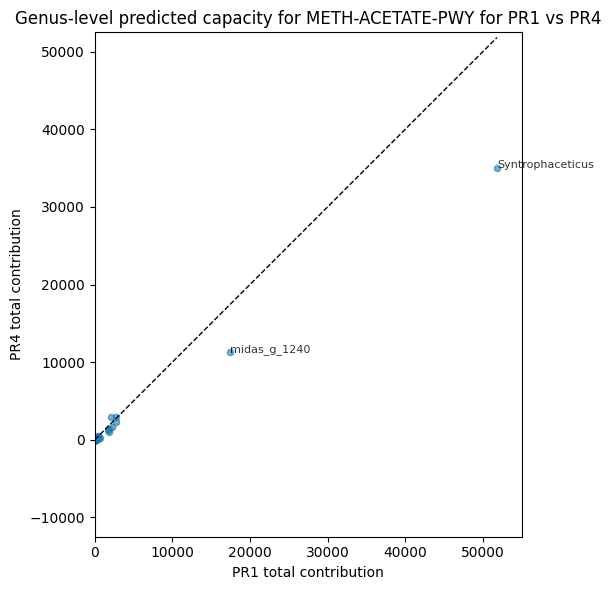

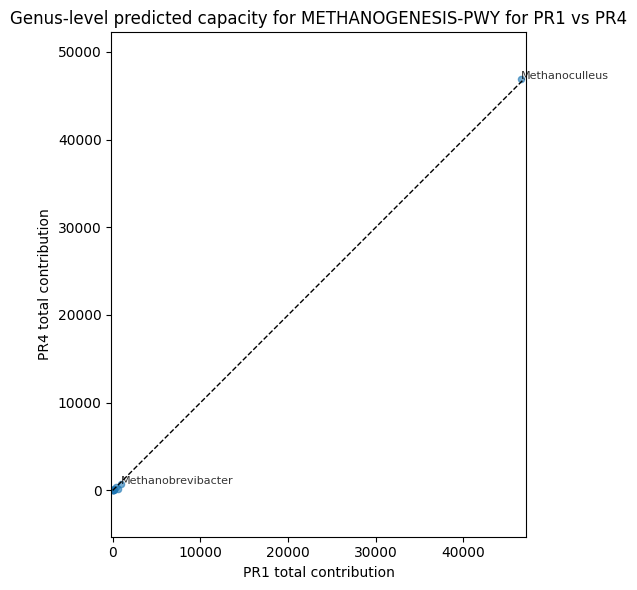

In [20]:
### Genus-level comparison of pathway abundances between PR1 and PR4



## Acetoclastic methanogenesis ##

# Genus level pathway abundance for acetoclastic methanogenesis
PR1_sub_ace = PR1_abun_genus[PR1_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()
PR4_sub_ace = PR4_abun_genus[PR4_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()


# Ensure the two columns exist and are numeric
merged_ace = PR1_sub_ace.merge(PR4_sub_ace, on='genus', how='outer',
                       suffixes=('_PR1','_PR4')).fillna(0)
for c in ['total_contribution_PR1','total_contribution_PR4']:
    merged_ace[c] = pd.to_numeric(merged_ace[c], errors='coerce').fillna(0)


# Scatterplot
plt.figure(figsize=(6,6))
x = merged_ace['total_contribution_PR1'].to_numpy()
y = merged_ace['total_contribution_PR4'].to_numpy()
top = merged_ace.nlargest(2, ['total_contribution_PR1', 'total_contribution_PR4']).copy()
for i, g in top.iterrows():
    plt.text(g['total_contribution_PR1'], g['total_contribution_PR4'], g['genus'], fontsize=8, alpha=0.8)
plt.scatter(x, y, alpha=0.6, s=20)
m = np.nanmax(np.concatenate([x, y]))  # numeric max only
plt.plot([0, m], [0, m], 'k--', linewidth=1)  # 1:1 diagonal
plt.xlabel('PR1 total contribution')
plt.ylabel('PR4 total contribution')
plt.title('Genus-level predicted capacity for METH-ACETATE-PWY for PR1 vs PR4')
plt.axis('equal'); plt.xlim(0, 55000); plt.ylim(0, 40000)
plt.tight_layout(); plt.show()




## Hydrogenotrophic methanogenesis ##

# Genus level pathway abundance for hydrogenotrophic methanogenesis
PR1_sub_hyd = PR1_abun_genus[PR1_abun_genus['function'] == 'METHANOGENESIS-PWY'].copy()
PR4_sub_hyd = PR4_abun_genus[PR4_abun_genus['function'] == 'METHANOGENESIS-PWY'].copy()


# Ensure the two columns exist and are numeric
merged_hyd = PR1_sub_hyd.merge(PR4_sub_hyd, on='genus', how='outer',
                       suffixes=('_PR1','_PR4')).fillna(0)
for c in ['total_contribution_PR1','total_contribution_PR4']:
    merged_hyd[c] = pd.to_numeric(merged_hyd[c], errors='coerce').fillna(0)


# Scatterplot
plt.figure(figsize=(6,6))
x = merged_hyd['total_contribution_PR1'].to_numpy()
y = merged_hyd['total_contribution_PR4'].to_numpy()
top = merged_hyd.nlargest(2, ['total_contribution_PR1', 'total_contribution_PR4']).copy()
for i, g in top.iterrows():
    plt.text(g['total_contribution_PR1'], g['total_contribution_PR4'], g['genus'], fontsize=8, alpha=0.8)
plt.scatter(x, y, alpha=0.6, s=20)
m = np.nanmax(np.concatenate([x, y]))  # numeric max only
plt.plot([0, m], [0, m], 'k--', linewidth=1)  # 1:1 diagonal
plt.xlabel('PR1 total contribution')
plt.ylabel('PR4 total contribution')
plt.title('Genus-level predicted capacity for METHANOGENESIS-PWY for PR1 vs PR4')
plt.axis('equal'); plt.xlim(0, m); plt.ylim(0, m)
plt.tight_layout(); plt.show()


In [8]:
### Top contributing genera for METH-ACETATE-PWY and METHANOGENESIS-PWY

top15_PR1_ace = PR1_sub_ace.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR4_ace = PR4_sub_ace.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR1_hyd = PR1_sub_hyd.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR4_hyd = PR4_sub_hyd.sort_values('total_contribution', ascending=False).head(15).copy()


print('The top 15 contributing genera for acetoclastic methanogenesis in PR1 are ' + ', '.join(top15_PR1_ace['genus'].tolist()))
print('The top 15 contributing genera for acetoclastic methanogenesis in PR4 are ' + ', '.join(top15_PR4_ace['genus'].tolist()))
print('The top 15 contributing genera for hydrogenotrophic methanogenesis in PR1 are ' + ', '.join(top15_PR1_hyd['genus'].tolist()))
print('The top 15 contributing genera for hydrogenotrophic methanogenesis in PR4 are ' + ', '.join(top15_PR4_hyd['genus'].tolist()))


The top 15 contributing genera for acetoclastic methanogenesis in PR1 are Syntrophaceticus, midas_g_1240, midas_g_4921, midas_g_90696, Romboutsia, midas_g_92005, Moorella, Paeniclostridium, Terrisporobacter, midas_g_93804, Desulfitibacter, midas_g_93820, midas_g_917, midas_g_91516, midas_g_5068
The top 15 contributing genera for acetoclastic methanogenesis in PR4 are Syntrophaceticus, midas_g_1240, midas_g_92005, midas_g_90696, midas_g_4921, Romboutsia, Paeniclostridium, Terrisporobacter, Moorella, midas_g_93820, midas_g_3406, Desulfitibacter, midas_g_99090, midas_g_93804, midas_g_917
The top 15 contributing genera for hydrogenotrophic methanogenesis in PR1 are Methanoculleus, Methanobrevibacter, Methanobacterium, Methanothermobacter, Methanosphaera, Methanosarcina, Ca_Methanofastidiosum, Methanocorpusculum, Methanothrix, Methanospirillum, Methanomethylovorans
The top 15 contributing genera for hydrogenotrophic methanogenesis in PR4 are Methanoculleus, Methanobrevibacter, Methanothermo

In [9]:
### Time-series pathway abundance

# Merging data
df = df_path_abun.merge(df_meta, left_on='sample', right_on='Barcode ', how='left').copy()


# Numeric values
df['taxon_function_abun'] = pd.to_numeric(df['taxon_function_abun'], errors='coerce').fillna(0)


# Convert date to datetime format
df['SampleDate'] = pd.to_datetime(df['SampleDate'], format='%m/%d/%Y').copy()


# Collapse to sample (instead of ASV)
df_col = (
    df
    .groupby(['sample', 'function'], as_index=False)
    .agg(
        function_abun=('taxon_function_abun', 'sum'),
        SampleDate=('SampleDate', 'first'),
        ReactorID=('ReactorID', 'first')
    )
    .copy()
)


# Add date column to df_col
#df_col = df_col.merge(df[['sample', 'SampleDate']], on='sample', how='left').copy()

In [10]:
print(df.head())

      sample    function             taxon taxon_abun  taxon_function_abun  \
0  barcode02  1CMET2-PWY  FLASV100006.1360        1.0                  1.0   
1  barcode02  1CMET2-PWY  FLASV100017.1355        6.0                  6.0   
2  barcode02  1CMET2-PWY  FLASV100031.1334        8.0                  8.0   
3  barcode02  1CMET2-PWY  FLASV100049.1361       43.0                 43.0   
4  barcode02  1CMET2-PWY  FLASV100055.1355        2.0                  2.0   

    Barcode  ReactorID SampleDate  
0  barcode02       PR1 2023-04-18  
1  barcode02       PR1 2023-04-18  
2  barcode02       PR1 2023-04-18  
3  barcode02       PR1 2023-04-18  
4  barcode02       PR1 2023-04-18  


Compared pairs: 24728
Pearson r: 0.949 | MAE: 7.96e+03 | MAPE: 59.37%
Unmatched functions (strat-only): 0
Unmatched functions (unstrat-only): 33
Unmatched samples (strat-only): 0
Unmatched samples (unstrat-only): 0


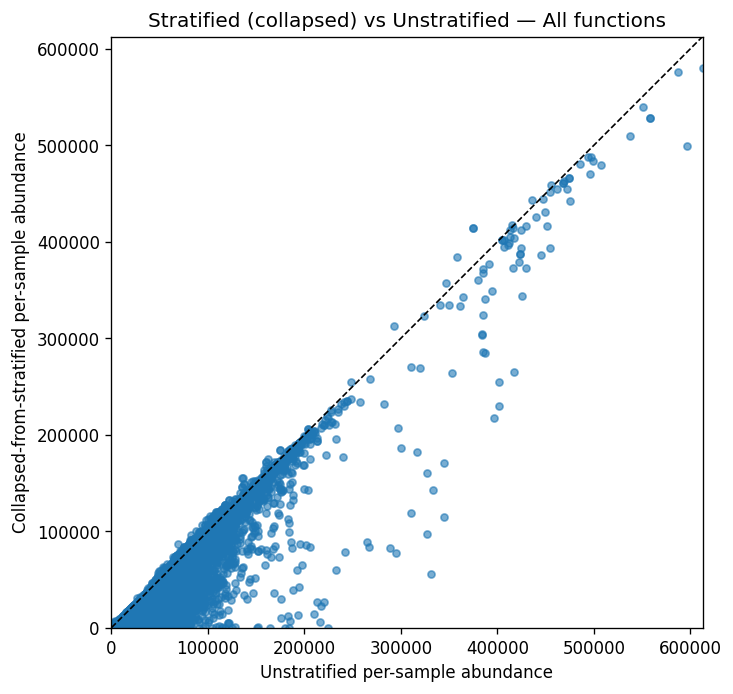

In [11]:
### Scatterplot: Stratified (collapsed) vs Unstratified

# ----------------------------
# 0) CONFIG
# ----------------------------
PATH = None   # e.g. 'METHANOGENESIS-PWY' or None for all functions

# ----------------------------
# 1) STRATIFIED → per-sample/per-function
# Expect: df_path_abun has ['sample','function','taxon_function_abun', ...]
# ----------------------------
df_strat = df_path_abun[['sample', 'function', 'taxon_function_abun']].copy()
df_strat['taxon_function_abun'] = pd.to_numeric(df_strat['taxon_function_abun'], errors='coerce').fillna(0)

df_strat = (df_strat
            .groupby(['sample','function'], as_index=False)['taxon_function_abun']
            .sum()
            .rename(columns={'taxon_function_abun':'from_strat'}))

# normalise keys
for c in ['sample','function']:
    df_strat[c] = df_strat[c].astype(str).str.strip().str.upper()

samples = pd.Index(df_strat['sample'].unique())

# ----------------------------
# 2) UNSTRATIFIED (wide) → long (sample,function,value)
# Rows = functions, columns = samples (+ maybe an ID col)
# ----------------------------
df_un = df_path_abun_unstrat.copy()

# normalise column headers (strip+upper) so they match 'samples'
df_un.columns = [c.strip().upper() for c in df_un.columns]
id_col = 'FUNCTION' if 'FUNCTION' in df_un.columns else ('PATHWAY' if 'PATHWAY' in df_un.columns else None)
if id_col is None:
    raise ValueError("Could not find function/pathway id column in unstratified table.")

# keep only actual sample columns that appear in stratified data
keep = [id_col] + [c for c in df_un.columns if c in samples]
df_un = df_un[keep].copy()

# melt to long
un_long = (df_un
           .melt(id_vars=[id_col], var_name='sample', value_name='from_unstrat')
           .rename(columns={id_col: 'function'}))

# normalise keys and values
for c in ['sample','function']:
    un_long[c] = un_long[c].astype(str).str.strip().str.upper()
un_long['from_unstrat'] = pd.to_numeric(
    un_long['from_unstrat'].astype(str).str.replace(',', '', regex=False),
    errors='coerce'
).fillna(0)

# ----------------------------
# 3) MERGE + DIAGNOSTICS
# ----------------------------
cmp = df_strat.merge(un_long, on=['sample','function'], how='outer')
cmp['from_strat']   = pd.to_numeric(cmp['from_strat'], errors='coerce').fillna(0)
cmp['from_unstrat'] = pd.to_numeric(cmp['from_unstrat'], errors='coerce').fillna(0)

# diffs
cmp['abs_diff'] = (cmp['from_strat'] - cmp['from_unstrat']).abs()
cmp['rel_diff'] = np.where(cmp['from_unstrat'] > 0,
                           cmp['abs_diff'] / cmp['from_unstrat'].abs(),
                           np.nan)

# optional filter to a specific pathway
plot_df = cmp if PATH is None else cmp[cmp['function'] == PATH].copy()

# consider pairs present in at least one dataset
mask = (plot_df['from_strat'] > 0) | (plot_df['from_unstrat'] > 0)
plot_df = plot_df[mask]

# summary stats
n_pairs = len(plot_df)
pearson = (np.corrcoef(plot_df['from_unstrat'], plot_df['from_strat'])[0,1]
           if n_pairs >= 2 else np.nan)
mae  = float(np.nanmean(plot_df['abs_diff']))
mape = float(np.nanmean(plot_df['rel_diff']) * 100)

print(f"Compared pairs: {n_pairs}")
print(f"Pearson r: {pearson:.3f} | MAE: {mae:.3g} | MAPE: {mape:.2f}%")

# quick mismatch sanity checks
print("Unmatched functions (strat-only):", len(set(df_strat['function']) - set(un_long['function'])))
print("Unmatched functions (unstrat-only):", len(set(un_long['function']) - set(df_strat['function'])))
print("Unmatched samples (strat-only):", len(set(df_strat['sample']) - set(un_long['sample'])))
print("Unmatched samples (unstrat-only):", len(set(un_long['sample']) - set(df_strat['sample'])))

# ----------------------------
# 4) SCATTER
# ----------------------------
x = plot_df['from_unstrat'].to_numpy()
y = plot_df['from_strat'].to_numpy()

plt.close('all')
fig, ax = plt.subplots(figsize=(6,6), dpi=120, constrained_layout=True)
ax.scatter(x, y, alpha=0.6, s=18)

m = float(np.nanmax(np.concatenate([np.nan_to_num(x), np.nan_to_num(y), [1]])))
ax.plot([0, m], [0, m], 'k--', linewidth=1)
title = 'All functions' if PATH is None else PATH
ax.set_title(f'Stratified (collapsed) vs Unstratified — {title}')
ax.set_xlabel('Unstratified per-sample abundance')
ax.set_ylabel('Collapsed-from-stratified per-sample abundance')
ax.set_xlim(0, m); ax.set_ylim(0, m); ax.set_aspect('equal', adjustable='box')



# label top discrepancies to inspect
#for _, r in plot_df.nlargest(12, 'abs_diff').iterrows():
#    ax.annotate(f"{r['sample']}|{r['function']}",
#                (r['from_unstrat'], r['from_strat']),
#                xytext=(3,3), textcoords='offset points', fontsize=7, alpha=0.8)


/tmp/ipykernel_372273/3321087558.py:91: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_372273/3321087558.py:98: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


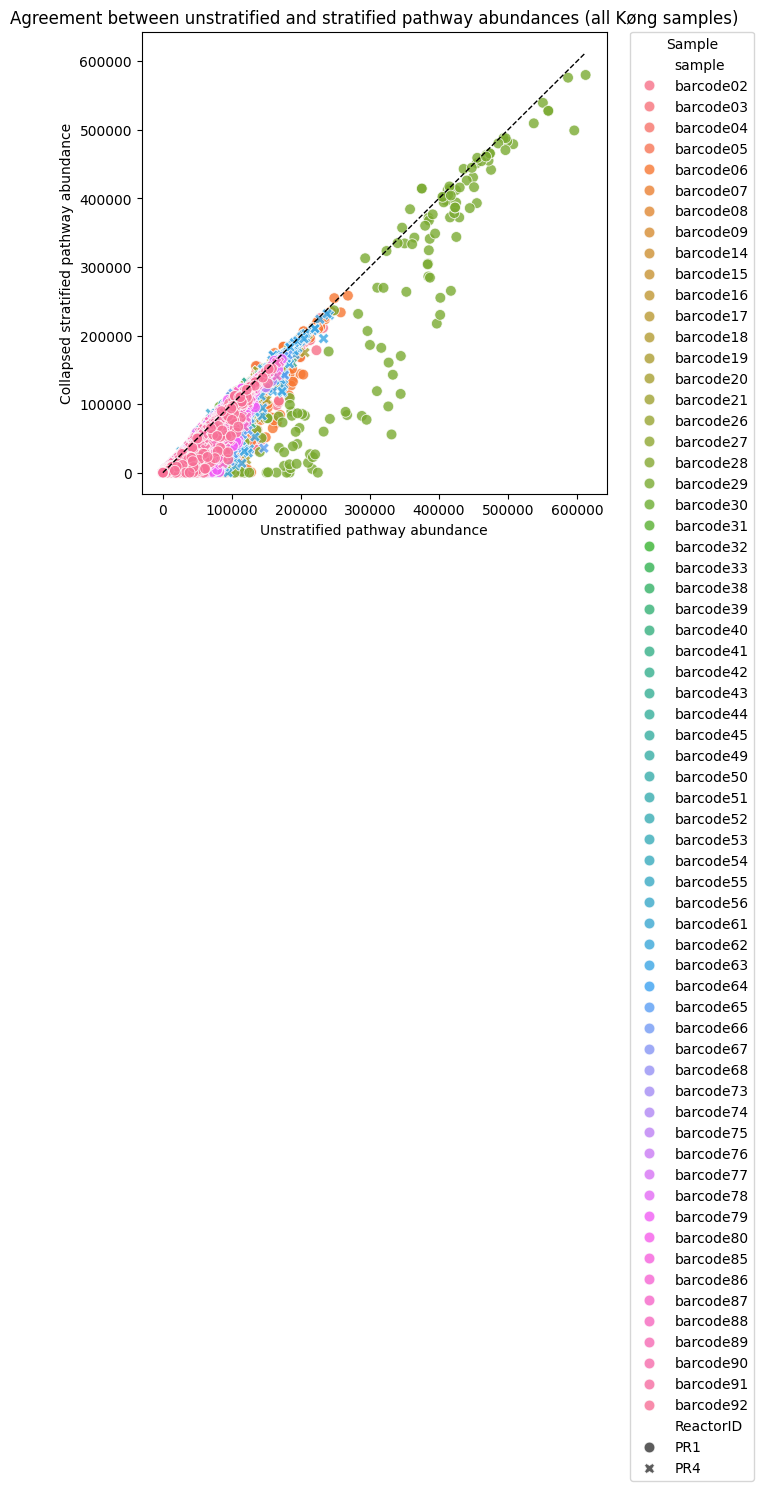

In [64]:
### Investigate discrepancy between collapsed stratified and unstratified results


## Building collapsed pathway abundance table from stratified data ##

# Numeric values
df_path_abun["taxon_function_abun"] = pd.to_numeric(
    df_path_abun["taxon_function_abun"], errors="coerce"
).fillna(0)


# Collapse to sample-function level
pathway_abundance = (
    df_path_abun.groupby(["sample", "function"], as_index=False)["taxon_function_abun"]
                .sum()
                .rename(columns={"taxon_function_abun": "total_pathway_abundance"})
)

pathway_abundance.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/collapsed_pathway_abundance.tsv', sep='\t', index=False)


## Align tables

# Convert df_path_abun_unstrat to long format
un_long = df_path_abun_unstrat.melt(id_vars=["pathway"],
                  var_name="sample",
                  value_name="pathway_abundance_unstrat")

# Clean up
un_long["sample"] = un_long["sample"].astype(str).str.strip()
un_long["pathway"] = un_long["pathway"].astype(str).str.strip()
un_long["pathway_abundance_unstrat"] = pd.to_numeric(
    un_long["pathway_abundance_unstrat"].astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace(r"[^\d\.\-eE+]", "", regex=True),
    errors="coerce"
).fillna(0)


# Numeric values
un_long["pathway_abundance_unstrat"] = pd.to_numeric(
    un_long["pathway_abundance_unstrat"], errors="coerce"
)


# Renaming
un_long = un_long.rename(columns={"pathway": "function"}).copy()
pathway_abundance = pathway_abundance.rename(columns={"total_pathway_abundance": "pathway_abundance_collapsed"}).copy()


# Merge
merged_comp = pathway_abundance.merge(
    un_long, on=["sample", "function"], how="inner"
)


## Compute differences ##

# Calculate some differences
merged_comp["difference"] = (
    merged_comp["pathway_abundance_unstrat"] - merged_comp["pathway_abundance_collapsed"]
)
merged_comp["relative_diff_%"] = (
    merged_comp["difference"] / merged_comp["pathway_abundance_collapsed"] * 100
)


## Add Group column to merged_comp ##

# Format: str
df_meta["ReactorID"] = df_meta["ReactorID"].astype(str).str.strip()
df_meta["sample"] = df_meta["sample"].astype(str).str.strip()
merged_comp["sample"] = merged_comp["sample"].astype(str).str.strip()

df_meta = df_meta.rename(columns={"Barcode ": "sample"}).copy()
merged_comp = merged_comp.merge(df_meta[["sample", "ReactorID"]], on="sample", how="left")


## Visualise: Scatterplot ##
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=merged_comp,
    x="pathway_abundance_unstrat",
    y="pathway_abundance_collapsed",
    hue="sample",      # colour by sample (barcodes)
    style="ReactorID",     # shape by group (metadata)
    alpha=0.8,
    s=60
)
plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.plot([0, merged_comp[["pathway_abundance_unstrat","pathway_abundance_collapsed"]].max().max()],
         [0, merged_comp[["pathway_abundance_unstrat","pathway_abundance_collapsed"]].max().max()],
         'k--', lw=1)
plt.xlabel("Unstratified pathway abundance")
plt.ylabel("Collapsed stratified pathway abundance")
plt.title("Agreement between unstratified and stratified pathway abundances (all Køng samples)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_372273/2481639063.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()
/tmp/ipykernel_372273/2481639063.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


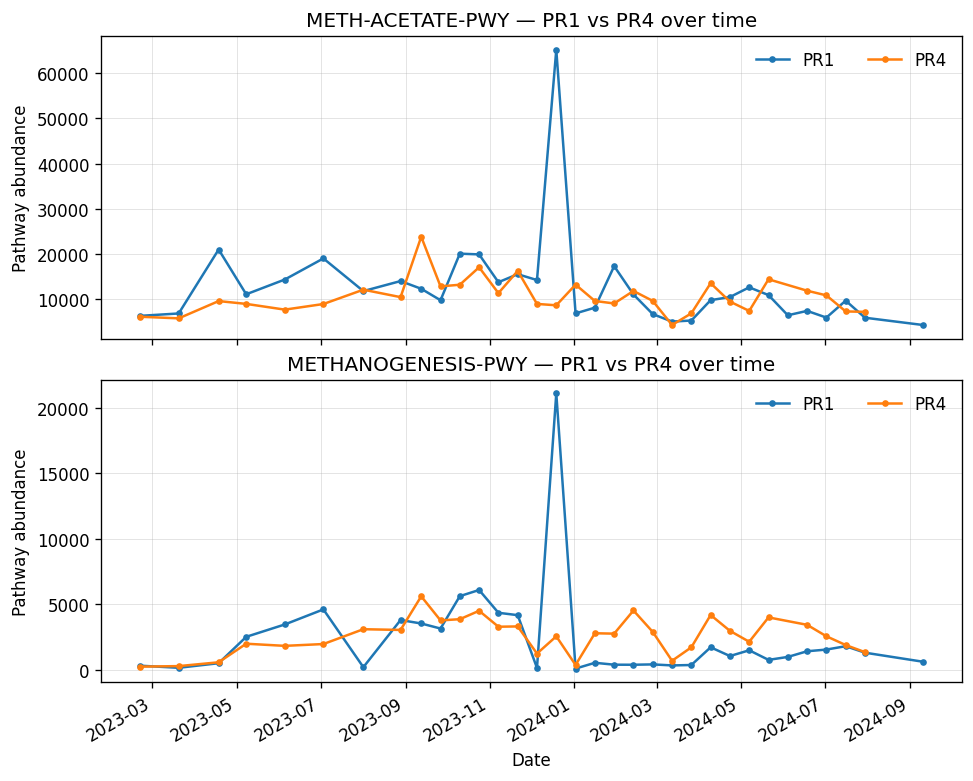

ReactorID                              PR1           PR4         DIFF
SampleDate function                                                  
2024-06-18 METH-ACETATE-PWY    7344.158871  11814.547036  4470.388165
           METHANOGENESIS-PWY  1417.523488   3433.076647  2015.553159
2024-07-02 METH-ACETATE-PWY    5859.498365  10779.526598  4920.028232
           METHANOGENESIS-PWY  1545.427581   2560.030856  1014.603274
2024-07-16 METH-ACETATE-PWY    9612.619196   7224.285062 -2388.334134
           METHANOGENESIS-PWY  1802.481592   1891.556546    89.074955
2024-07-30 METH-ACETATE-PWY    5827.291028   7130.691329  1303.400300
           METHANOGENESIS-PWY  1308.400987   1349.102410    40.701423
2024-09-10 METH-ACETATE-PWY    4219.608293      0.000000 -4219.608293
           METHANOGENESIS-PWY   620.100008      0.000000  -620.100008


In [12]:
### Pathway abundance over time in PR1 and PR4


# ---- CONFIG ----
PATHS = {'METHANOGENESIS-PWY', 'METH-ACETATE-PWY'}  # edit as needed

# ---- 1) Clean metadata (dates + IDs) ----
m = df_meta.copy()
m.columns = m.columns.str.strip()
# harmonise column names
barcode_col = 'Barcode' if 'Barcode' in m.columns else ('Barcode ' if 'Barcode ' in m.columns else None)
if barcode_col is None:
    raise ValueError("df_meta must contain a 'Barcode' column (allowing trailing space).")
m = m.rename(columns={barcode_col: 'sample'})
m['sample'] = m['sample'].astype(str).str.strip().str.upper()
m['ReactorID'] = m['ReactorID'].astype(str).str.strip().str.upper()
m['SampleDate'] = pd.to_datetime(m['SampleDate'], errors='coerce')

# Keep only PR1/PR4
m = m[m['ReactorID'].isin(['PR1','PR4'])].copy()

# ---- 2) Unstratified (wide) → long ----
u = df_path_abun_unstrat.copy()
u.columns = [c.strip().upper() for c in u.columns]
id_col = 'FUNCTION' if 'FUNCTION' in u.columns else ('PATHWAY' if 'PATHWAY' in u.columns else None)
if id_col is None:
    raise ValueError("Unstratified table needs an ID column named 'function' or 'pathway'.")
# keep only barcodes present in metadata (PR1/PR4)
keep = [id_col] + [c for c in u.columns if c in set(m['sample'])]
u = u[keep].copy()

long_u = (u.melt(id_vars=[id_col], var_name='sample', value_name='abun')
            .rename(columns={id_col: 'function'}))
long_u['sample'] = long_u['sample'].astype(str).str.strip().str.upper()
long_u['function'] = long_u['function'].astype(str).str.strip().str.upper()
long_u['abun'] = pd.to_numeric(long_u['abun'], errors='coerce').fillna(0)

# ---- 3) Attach ReactorID + Date, filter pathways and reactors ----
sub = (long_u.merge(m[['sample','SampleDate','ReactorID']], on='sample', how='inner')
             .query("function in @PATHS and ReactorID in ['PR1','PR4']"))

# ---- 4) Aggregate by date × reactor × pathway (sum or median) ----
ts = (sub.groupby(['SampleDate','ReactorID','function'], as_index=False)['abun']
          .sum()
          .sort_values(['function','SampleDate','ReactorID']))

# ---- 5) Plot: one panel per pathway, PR1 vs PR4 lines ----
plt.close('all')
paths_sorted = sorted(PATHS)
fig, axes = plt.subplots(nrows=len(paths_sorted), ncols=1, figsize=(8, 3.2*len(paths_sorted)), dpi=120, constrained_layout=True)

if len(paths_sorted) == 1:
    axes = [axes]

for ax, pw in zip(axes, paths_sorted):
    g = ts[ts['function'] == pw]
    for rid, gg in g.groupby('ReactorID'):
        ax.plot(gg['SampleDate'], gg['abun'], marker='o', linewidth=1.5, markersize=3, label=rid)
    ax.set_title(f"{pw} — PR1 vs PR4 over time")
    ax.set_xlabel("Date"); ax.set_ylabel("Pathway abundance")
    ax.grid(True, linewidth=0.4, alpha=0.5)
    ax.legend(frameon=False, ncol=2)
    fig.autofmt_xdate()

plt.show()

# (Optional) table of PR1/PR4 and their difference per date+pathway
wide = (ts.pivot_table(index=['SampleDate','function'], columns='ReactorID', values='abun', fill_value=0)
          .assign(DIFF=lambda d: d.get('PR4',0) - d.get('PR1',0))
          .sort_index())
print(wide.tail(10))



In [63]:
print(merged_comp.head())

      sample                                function  \
0  barcode02                              1CMET2-PWY   
1  barcode02  3-HYDROXYPHENYLACETATE-DEGRADATION-PWY   
2  barcode02                       AEROBACTINSYN-PWY   
3  barcode02                      ALL-CHORISMATE-PWY   
4  barcode02                        ANAEROFRUCAT-PWY   

   pathway_abundance_collapsed  pathway_abundance_unstrat    difference  \
0                 39447.879161              102062.934814  62615.055653   
1                     6.769858                 152.133596    145.363738   
2                     0.830000                   1.445343      0.615343   
3                     0.379926                 172.542318    172.162391   
4                  3434.220653               76096.788314  72662.567661   

   relative_diff_% ReactorID  
0       158.728573       PR1  
1      2147.219802       PR1  
2        74.137651       PR1  
3     45314.693170       PR1  
4      2115.838643       PR1  
